# Enhanced Documentation Repository EDA - Comprehensive Analysis

This notebook provides a comprehensive exploratory data analysis of the BlueXP documentation repository, including:
- File structure and organization patterns
- Content analysis and quality metrics
- Documentation completeness assessment
- Naming conventions and consistency
- Interactive visualizations and insights


## Notebook Imports

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
def scan_documentation_repo(repo_path, file_extensions=['.adoc', '.md', '.yml', '.yaml', '.json']):
    files_data = []
    
    for root, dirs, files in os.walk(repo_path):
    
        for file in files:
            if any(file.endswith(ext) for ext in file_extensions):
                file_path = Path(root) / file
                relative_path = file_path.relative_to(repo_path)
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                    
                    files_data.append({
                        'filename': file,
                        'path': str(relative_path),
                        'directory': str(relative_path.parent),
                        'extension': file_path.suffix,
                        'size_bytes': file_path.stat().st_size,
                        'content': content,
                        'depth': len(relative_path.parts) - 1
                    })
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    
    return pd.DataFrame(files_data)

df = scan_documentation_repo('../data/bluexp-dataset')
print(f"Loaded {len(df)} documentation files")
df.head()

Loaded 194 documentation files


,filename,path,directory,extension,size_bytes,content,depth
0,legal-notices.adoc,legal-notices.adoc,.,.adoc,516,// uuid: 80e4f7bb-32c7-594b-8c6b-034c42b4a3b6\...,0
1,project.yml,project.yml,.,.yml,745,uuid: d418768b-3497-547c-af79-bf44964603cc\nse...,0
2,README.md,README.md,.,.md,557,# BlueXP Automation\n\nWelcome to the open-sou...,0
3,_index.yml,_index.yml,.,.yml,3463,uuid: 14df382f-48fa-5fd7-a8f0-40ee98580bd4\nin...,0
4,sidebar.yml,api-cm\sidebar.yml,api-cm,.yml,13142,uuid: 55909472-99fa-5a23-bdc9-74ab1f4f12be\nse...,1


## <span style="color: lightblue;">Exploratory Data Analysis (EDA)</span>

#### Now that we have our repo dataset captured in a Pandas Dataframe, we can begin our EDA:  
1. **_<span style="color: lightblue;">Defining Helper Functions & Key Statistics/Repo Summary:</span>_**
We start by defining our helper functions to process the dataset and extract key metrics and statistics.  The output of this processing steps is a refined Dataframe that contains key attributes of our dataset and a summary of the dataset's key characteristics.
<br/><br/>

2. **_<span style="color: lightblue;">File Size & Types:</span>_**
Because the research in this project is intended to apply to vast amounts of other documentation, we need to look at the file size and type to account for scalability considerations and to understand how the content in this repository is contained (for example markup text in adocs vs. key/value pairs in the json files).
<br/><br/>

3. **_<span style="color: lightblue;">Directory Analysis:</span>_**
The nature of the repo's structure is critical towards establishing relationships and identifying general semantic meaning of the repo's purpose (what does this repo do?).  This section of the EDA is focused on analyzing directory depth (how deep files were nested in subdirectories), highest file counts, and highest word counts.  



#### 1. Defining Helper Functions & Key Statistics/Repo Summary
Because our dataset consists of various file types, each containing their own nuiances in terms of structure, we must take into accont *how* we extract this data (i.e. separating the logic to properly handle markup language, key/value pairs, etc.). 

In [3]:
def analyze_content_metrics(df):    

    df['line_count'] = df['content'].apply(lambda x: len(x.split('\n')))
    df['word_count'] = df['content'].apply(lambda x: len(x.split()))
    df['char_count'] = df['content'].apply(len)
    df['avg_line_length'] = df['char_count'] / df['line_count']
    df['avg_word_length'] = df['char_count'] / df['word_count']
    
    def count_headers(content, extension):
        if extension in ['.md']:
            # Markdown headers
            h1 = len(re.findall(r'^# ', content, re.MULTILINE))
            h2 = len(re.findall(r'^## ', content, re.MULTILINE))
            h3 = len(re.findall(r'^### ', content, re.MULTILINE))
        elif extension in ['.adoc']:
            # AsciiDoc headers
            h1 = len(re.findall(r'^= ', content, re.MULTILINE))
            h2 = len(re.findall(r'^== ', content, re.MULTILINE))
            h3 = len(re.findall(r'^=== ', content, re.MULTILINE))
        else:
            # JSON/YAML files don't have headers
            h1, h2, h3 = 0, 0, 0
        return h1, h2, h3
    
    header_counts = df.apply(lambda row: count_headers(row['content'], row['extension']), axis=1)
    df['h1_count'] = [counts[0] for counts in header_counts]
    df['h2_count'] = [counts[1] for counts in header_counts]
    df['h3_count'] = [counts[2] for counts in header_counts]
    df['total_headers'] = df['h1_count'] + df['h2_count'] + df['h3_count']
    
    def count_links(content, extension):
        if extension in ['.md']:
            # Markdown links
            internal = len(re.findall(r'\[.*?\]\((?!http)', content))
            external = len(re.findall(r'\[.*?\]\(http', content))
        elif extension in ['.adoc']:
            # AsciiDoc links
            internal = len(re.findall(r'<<[^>]+>>', content)) 
            external = len(re.findall(r'link:https?://[^\s\]]+', content))
        else:
            # JSON/YAML files don't typically have links
            internal, external = 0, 0
        return internal, external
    
    link_counts = df.apply(lambda row: count_links(row['content'], row['extension']), axis=1)
    df['internal_links'] = [counts[0] for counts in link_counts]
    df['external_links'] = [counts[1] for counts in link_counts]
    df['total_links'] = df['internal_links'] + df['external_links']
    df['link_density'] = (df['total_links'] / df['word_count'] * 100).fillna(0)
    
    def count_code_blocks(content, extension):
        if extension in ['.md']:
            # Markdown code blocks
            code_blocks = len(re.findall(r'```', content)) // 2
        elif extension in ['.adoc']:
            # AsciiDoc code blocks
            code_blocks = len(re.findall(r'^----$', content, re.MULTILINE)) // 2
        else:
            # JSON/YAML files are essentially code themselves
            code_blocks = 1 if len(content.strip()) > 0 else 0
        return code_blocks
    
    df['code_blocks'] = df.apply(lambda row: count_code_blocks(row['content'], row['extension']), axis=1)
    df['inline_code'] = df['content'].apply(lambda x: len(re.findall(r'`[^`]+`', x)))
    df['api_endpoints'] = df['content'].apply(lambda x: len(re.findall(r'/api/|/v\d+/', x)))
    
    # Quality indicators - Different logic for different file types
    def check_quality_indicators(content, extension):
        if extension in ['.md', '.adoc']:
            # Documentation files
            has_toc = 'table of contents' in content.lower() or 'toc' in content.lower()
            has_examples = 'example' in content.lower()
        else:
            # JSON/YAML files - check for structure indicators
            has_toc = False  # No TOC in config files
            has_examples = 'example' in content.lower() or 'sample' in content.lower()
        return has_toc, has_examples
    
    quality_checks = df.apply(lambda row: check_quality_indicators(row['content'], row['extension']), axis=1)
    df['has_toc'] = [check[0] for check in quality_checks]
    df['has_examples'] = [check[1] for check in quality_checks]
    
    # Content categories
    df['is_config'] = df['extension'].isin(['.yml', '.yaml', '.json'])
    df['is_documentation'] = df['extension'].isin(['.md', '.adoc'])
    
    return df

df = analyze_content_metrics(df)
df[['filename', 'extension', 'word_count', 'total_headers', 'total_links', 'code_blocks']].head()

,filename,extension,word_count,total_headers,total_links,code_blocks
0,legal-notices.adoc,.adoc,46,1,0,0
1,project.yml,.yml,83,0,0,1
2,README.md,.md,75,1,1,0
3,_index.yml,.yml,377,0,0,1
4,sidebar.yml,.yml,1158,0,0,1


In [4]:
def generate_comprehensive_insights(df):    
    insights = {}
    doc_files = df[df['is_documentation']]
    config_files = df[df['is_config']]
    
    # Basic statistics
    insights['total_files'] = len(df)
    insights['documentation_files'] = len(doc_files)
    insights['config_files'] = len(config_files)
    insights['avg_file_size'] = df['size_bytes'].mean()
    insights['total_content_size'] = df['size_bytes'].sum()
    
    # Content quality metrics
    insights['avg_word_count'] = doc_files['word_count'].mean()
    insights['total_words'] = doc_files['word_count'].sum()
    insights['files_with_structure'] = (doc_files['total_headers'] > 0).sum()
    insights['files_with_examples'] = doc_files['has_examples'].sum()
    insights['files_with_code'] = (doc_files['code_blocks'] > 0).sum()
    
    # Directory analysis
    insights['unique_directories'] = df['directory'].nunique()
    insights['max_depth'] = df['depth'].max()
    insights['avg_files_per_dir'] = len(df) / df['directory'].nunique()
    
    # Quality indicators
    insights['documentation_completeness'] = {
        'with_headers': (doc_files['total_headers'] > 0).sum() / len(doc_files) * 100,
        'with_links': (doc_files['total_links'] > 0).sum() / len(doc_files) * 100,
        'with_examples': doc_files['has_examples'].sum() / len(doc_files) * 100,
        'with_code_blocks': (doc_files['code_blocks'] > 0).sum() / len(doc_files) * 100,
        'with_toc': doc_files['has_toc'].sum() / len(doc_files) * 100
    }
    
    # Content distribution
    insights['file_type_distribution'] = df['extension'].value_counts().to_dict()
    insights['top_directories'] = df['directory'].value_counts().head(5).to_dict()
    
    return insights

def print_insights_report(insights):
        
    print(f"\n Repo Overview")
    print(f"   • Total Files: {insights['total_files']:,}")
    print(f"   • Documentation Files: {insights['documentation_files']:,} ({insights['documentation_files']/insights['total_files']*100:.1f}%)")
    print(f"   • Configuration Files: {insights['config_files']:,} ({insights['config_files']/insights['total_files']*100:.1f}%)")
    print(f"   • Total Content Size: {insights['total_content_size']/1024:.1f} KB")
    print(f"   • Average File Size: {insights['avg_file_size']:.0f} bytes")
    
    print(f"\n Content")
    print(f"   • Total Words: {insights['total_words']:,}")
    print(f"   • Average Words per Document: {insights['avg_word_count']:.0f}")
    
    print(f"\n STRUCTURE")
    print(f"   • Unique Directories: {insights['unique_directories']}")
    print(f"   • Maximum Directory Depth: {insights['max_depth']}")
    print(f"   • Average Files per Directory: {insights['avg_files_per_dir']:.1f}")
    
    print(f"\n DOCUMENTATION QUALITY METRICS")
    completeness = insights['documentation_completeness']
    print(f"   • Files with Headers: {completeness['with_headers']:.1f}%")
    print(f"   • Files with Links: {completeness['with_links']:.1f}%")
    print(f"   • Files with Examples: {completeness['with_examples']:.1f}%")
    print(f"   • Files with Code Blocks: {completeness['with_code_blocks']:.1f}%")
    print(f"   • Files with Table of Contents: {completeness['with_toc']:.1f}%")
    
    print(f"\n📁 FILE TYPE DISTRIBUTION")
    for ext, count in insights['file_type_distribution'].items():
        percentage = count / insights['total_files'] * 100
        print(f"   • {ext}: {count} files ({percentage:.1f}%)")
    
    print(f"\n🔝 TOP DIRECTORIES")
    for directory, count in insights['top_directories'].items():
        print(f"   • {directory}: {count} files")
    
insights = generate_comprehensive_insights(df)
print_insights_report(insights)


 Repo Overview
   • Total Files: 194
   • Documentation Files: 159 (82.0%)
   • Configuration Files: 35 (18.0%)
   • Total Content Size: 3448.8 KB
   • Average File Size: 18204 bytes

 Content
   • Total Words: 129,725
   • Average Words per Document: 816

 STRUCTURE
   • Unique Directories: 16
   • Maximum Directory Depth: 1
   • Average Files per Directory: 12.1

 DOCUMENTATION QUALITY METRICS
   • Files with Headers: 100.0%
   • Files with Links: 61.0%
   • Files with Examples: 89.3%
   • Files with Code Blocks: 39.0%
   • Files with Table of Contents: 20.1%

📁 FILE TYPE DISTRIBUTION
   • .adoc: 158 files (81.4%)
   • .yml: 18 files (9.3%)
   • .json: 16 files (8.2%)
   • .md: 1 files (0.5%)
   • .yaml: 1 files (0.5%)

🔝 TOP DIRECTORIES
   • cm: 139 files
   • platform: 17 files
   • .: 4 files
   • automate: 3 files
   • copysync: 3 files


#### 2. File Types & Sizes

#### _File Types_

The repo consists of a total of five (5) file types:
- AsciiDoc (adoc)
- JSON
- YML
- YMAL
- MD (README)

As can be seen in the below visualization, the preponderance of these files are adoc files.  These represent the web pages of the official BlueXP-Automation API documentation.  Because adoc files inherently have rich markup, these files will be critical to our strategy in conducting semantic understanding of the repo's/files' contents to generate enriched metadata.

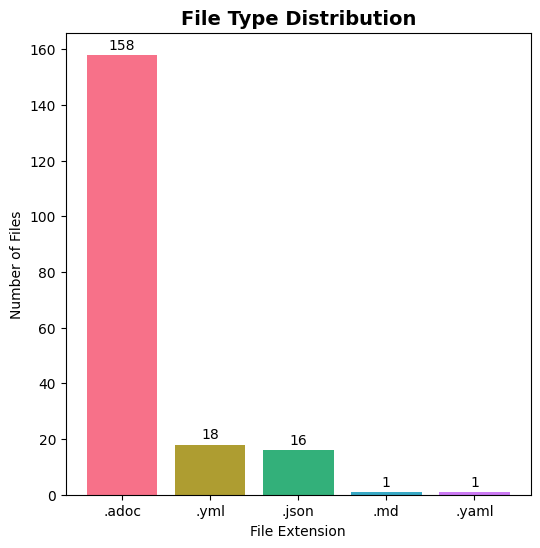

In [5]:
plt.figure(figsize=(6, 6))

ext_counts = df['extension'].value_counts()
bars = plt.bar(ext_counts.index, ext_counts.values, color=sns.color_palette("husl", len(ext_counts)))

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1, 
             f'{int(height)}', ha='center', va='bottom')

plt.title('File Type Distribution', fontsize=14, fontweight='bold')
plt.ylabel('Number of Files')
plt.xlabel('File Extension')

plt.show()

#### _File Sizes_


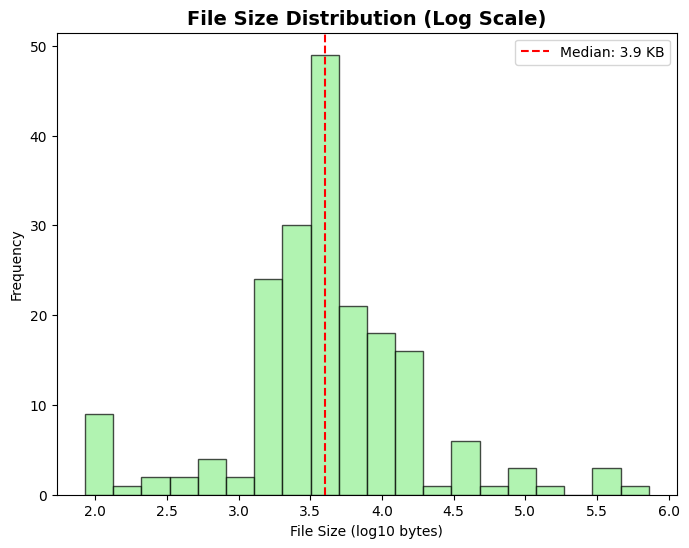

In [6]:
plt.figure(figsize=(8, 6))
plt.hist(np.log10(df['size_bytes']), bins=20, color='lightgreen', alpha=0.7, edgecolor='black')
plt.xlabel('File Size (log10 bytes)')
plt.ylabel('Frequency')
plt.title('File Size Distribution (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(np.log10(df['size_bytes'].median()), color='red', linestyle='--', 
           label=f'Median: {df["size_bytes"].median()/1024:.1f} KB')
plt.legend()
plt.show()

### <span style="color: lightblue;">Directory Analysis:</span>

#### _Directory Depth_
The repo consists of numerous subdirectories (15) and files (194).  The vast majority of the files (97%) have a depth of 1, meaning that they are nested in a subdirectory folder and therefore we will need to consider the appropriate methods to crawl/walk through repo hierarchy to absorb file contents.  Additionally, depth (nested files) are important when considering graph modeling.

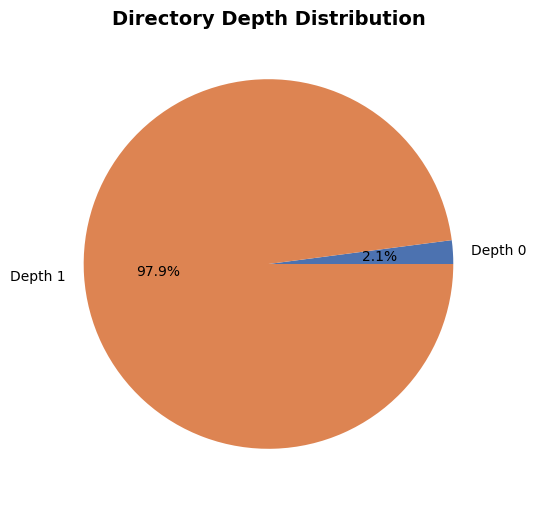

Total files at depth 0: 4
Total files at depth 1: 190


In [7]:
plt.figure(figsize=(8, 6))

depth_counts = df['depth'].value_counts().sort_index()
colors = sns.color_palette("deep", len(depth_counts))
wedges, texts, autotexts = plt.pie(depth_counts.values, labels=[f'Depth {d}' for d in depth_counts.index], 
                                  autopct='%1.1f%%', colors=colors)
plt.title('Directory Depth Distribution', fontsize=14, fontweight='bold')

plt.show()

print(f"Total files at depth 0: {depth_counts[0]}")
print(f"Total files at depth 1: {depth_counts[1]}")

#### _Directories with the Highest File Count_
The bar chart below shows the top 10 directories in the repository by file count. The `cm/` directory, short for Cloud Management, contains the overwhelming majority of files. It includes dozens of .adoc documents detailing workflows and API procedures for operating the BlueXP platform across cloud providers such as AWS, Azure, and Google Cloud. Since most of the documentation consists of technical task walkthroughs, we will tailor our metadata approach to reflect this structure and content focus.

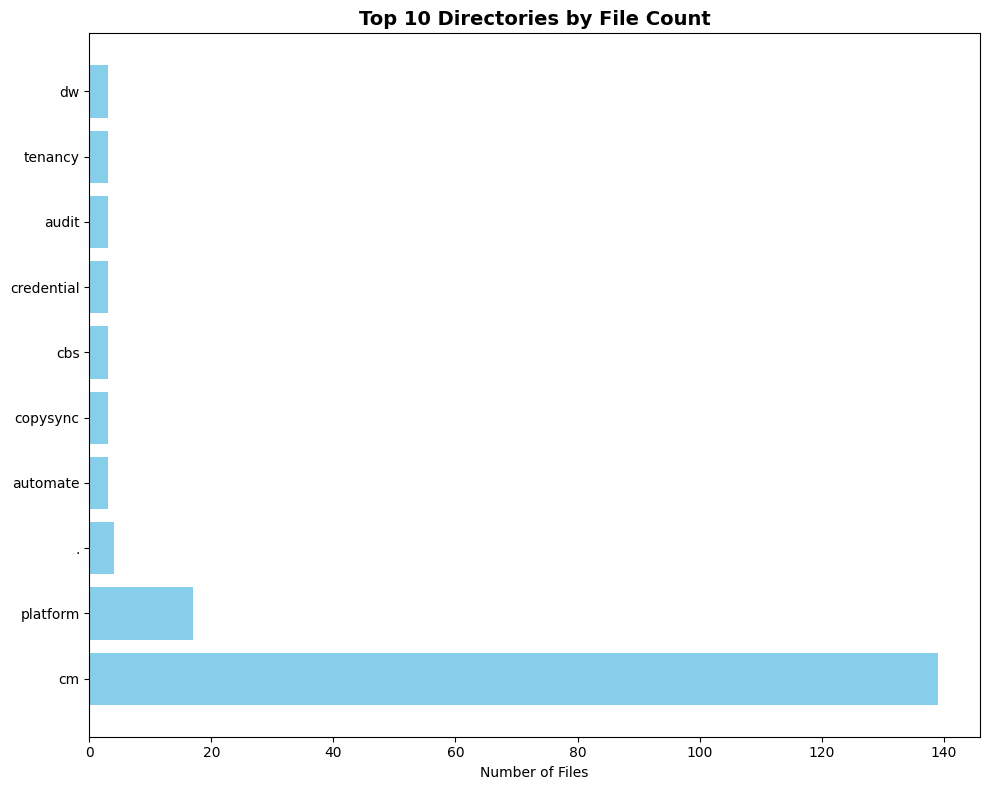

In [8]:
top_dirs = df['directory'].value_counts().head(10)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_dirs)), top_dirs.values, color='skyblue')
plt.yticks(range(len(top_dirs)), [d[:20] + '...' if len(d) > 20 else d for d in top_dirs.index])
plt.xlabel('Number of Files')
plt.title('Top 10 Directories by File Count', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### <span style="color: lightblue;">Document Analysis?:</span>

### _Word Counts by File_
The median file length is 415 words, but a small number of outliers significantly exceed this, with word counts ranging up to nearly 40,000. These outliers include large JSON and YAML files as well as a few long `.adoc` documents such as `api_ref_resources.adoc` and `api_ref_definitions.adoc`. To better understand the typical content length, we excluded the top 5% of files by word count in a secondary plot. This better illustrates that the vast majority of documents are short to medium in length and thus fairly processable at the full-text level. However, a small number of longer files—particularly large JSON, YAML, or reference `.adoc` documents—may require special handling to avoid skewing metadata extraction or downstream analysis.

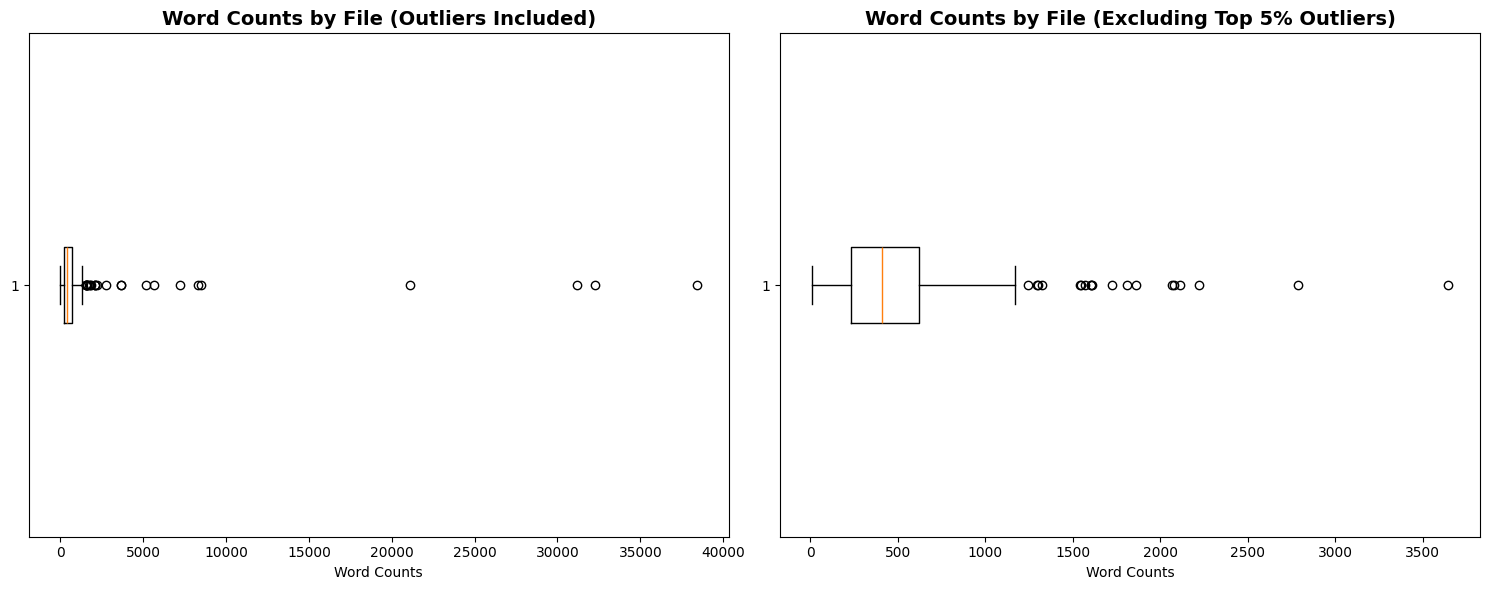

Median word count: 415.0

Number of outliers: 10

Outlier file names:

 ['cbs.json' 'api_ref_definitions.adoc' 'api_ref_resources.adoc'
 'wf_azure_cloud_md_get_storage_account_types.adoc' 'copysync.json'
 'dw.json' 'ipa.json' 'tenancy.json' 'tenancyv4-x-doc.yml'
 'tenancyv4.yaml']


In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.boxplot(df['word_count'], vert=False)
ax1.set_xlabel('Word Counts')
ax1.set_title('Word Counts by File (Outliers Included)', fontsize=14, fontweight='bold')

q95 = df['word_count'].quantile(0.95)
filtered_data = df[df['word_count'] <= q95]
ax2.boxplot(filtered_data['word_count'], vert=False)
ax2.set_xlabel('Word Counts')
ax2.set_title('Word Counts by File (Excluding Top 5% Outliers)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

median_word_count = df['word_count'].median()
print(f"Median word count: {median_word_count}\n")

outliers = df[df['word_count'] > q95]
print(f"Number of outliers: {len(outliers)}\n")
print("Outlier file names:\n\n", outliers['filename'].values)


### _Header Counts_

Upon investigation, many of our files have numerous layers of headers (H1, H2, and H3).  H3s dominate the count of headers across our files (specifically adoc files), reflecting that these files have depth in file contents and are likely well organized.  This is beneficial for our task of analyzing the contents and prioritizing the various sections (headers).

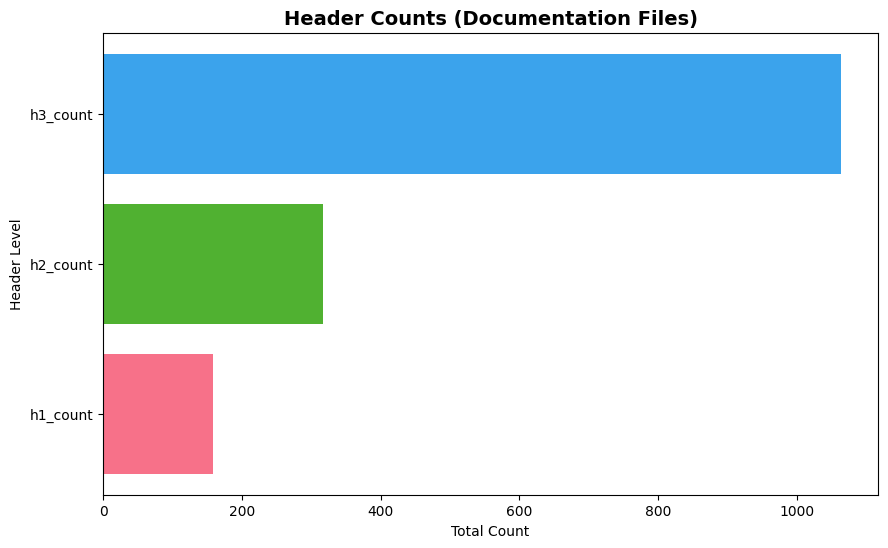

Total H1 headers: 159
Total H2 headers: 317
Total H3 headers: 1064


In [10]:
doc_files = df[df['is_documentation']]
structure_data = doc_files[['h1_count', 'h2_count', 'h3_count']].sum()

plt.figure(figsize=(10, 6))
plt.barh(structure_data.index, structure_data.values, color=sns.color_palette("husl", len(structure_data)))
plt.title('Header Counts (Documentation Files)', fontsize=14, fontweight='bold')
plt.xlabel('Total Count')
plt.ylabel('Header Level')
plt.show()

print(f"Total H1 headers: {structure_data['h1_count']}")
print(f"Total H2 headers: {structure_data['h2_count']}")
print(f"Total H3 headers: {structure_data['h3_count']}")

### _Link Analysis_
Links can be a good indicator of a file's dependency on external sources, as well as be helpful establishing relationships with various files, concepts, or other resources.  In the case of the BlueXP-Automation API, a large amount of the repo (61% of files) has links.  Upon further analysis, however, the majority of those links are internal links, meaning the dependencies are within the repo.  

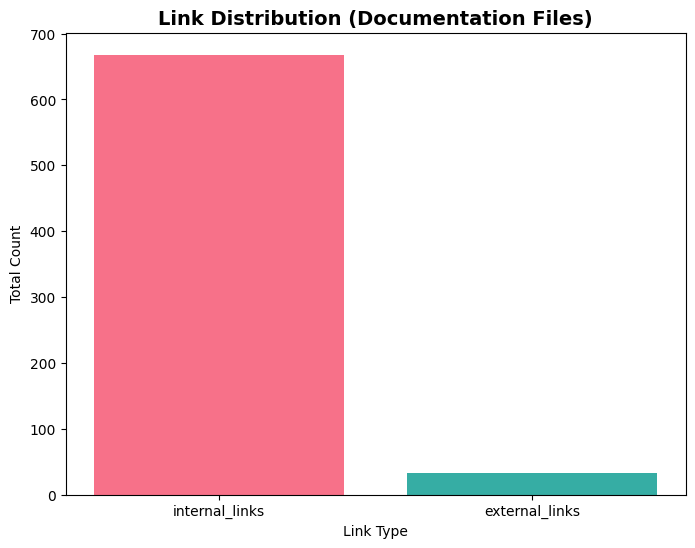

Total internal links: 668
Total external links: 33
Files containing links: 97
Percentage of files with links: 61.0%


In [11]:
link_data = doc_files[['internal_links', 'external_links']].sum()

plt.figure(figsize=(8, 6))
plt.bar(link_data.index, link_data.values, color=sns.color_palette("husl", len(link_data)))
plt.title('Link Distribution (Documentation Files)', fontsize=14, fontweight='bold')
plt.ylabel('Total Count')
plt.xlabel('Link Type')
plt.show()

print(f"Total internal links: {link_data['internal_links']}")
print(f"Total external links: {link_data['external_links']}")
print(f"Files containing links: {(doc_files['total_links'] > 0).sum()}")
print(f'Percentage of files with links: {(doc_files["total_links"] > 0).sum() / len(doc_files) * 100:.1f}%')

### _Content Pattern Analysis_
First, extract structural features from each document, including header counts (h1–h3), internal/external links, API mentions, and overall size (lines, words, characters). These features will help us evaluate content patterns and assess document complexity.


In [12]:
def analyze_content_patterns(df):
    
    metrics = []
    
    for idx, row in df.iterrows():
        content = row['content']
        
        lines = content.split('\\n')
        words = content.split()
        
        # Capturing the h1, 2, and 3 headers
        h1_count = len(re.findall(r'^= .+', content, re.MULTILINE))
        h2_count = len(re.findall(r'^== .+', content, re.MULTILINE))
        h3_count = len(re.findall(r'^=== .+', content, re.MULTILINE))
        
        # Capturing the internal and external links in the files
        internal_links = len(re.findall(r'<<[^>]+>>', content))
        external_links = len(re.findall(r'https?://[^\\s]+', content))
        
        # Looking for API endpoints used in the files
        api_endpoints = len(re.findall(r'/(api|v\\d+)/[^\\s]+', content))
        
        metrics.append({
            'filename': row['filename'],
            'line_count': len(lines),
            'word_count': len(words),
            'char_count': len(content),
            'h1_count': h1_count,
            'h2_count': h2_count,
            'h3_count': h3_count,
            'internal_links': internal_links,
            'external_links': external_links,
            'link_density': (internal_links + external_links) / max(len(words), 1) * 100,
            'api_endpoints': api_endpoints,
        })
    
    return pd.DataFrame(metrics)

content_metrics = analyze_content_patterns(df)
content_metrics.head()

,filename,line_count,word_count,char_count,h1_count,h2_count,h3_count,internal_links,external_links,link_density,api_endpoints
0,legal-notices.adoc,1,46,497,1,0,0,0,1,2.173913,0
1,project.yml,1,83,710,0,0,0,0,0,0.000000,0
2,README.md,1,75,550,0,0,0,0,2,2.666667,0
3,_index.yml,1,377,3384,0,0,0,0,2,0.530504,0
4,sidebar.yml,1,1158,12819,0,0,0,0,0,0.000000,0


### _Content Complexity Score_
We calculate a weighted complexity score for each document based on normalized values for word count, header depth, code block count, and link density. This helps distinguish structurally complex files—such as detailed JSON definitions, API reference docs, and identity workflows—from simpler documents like overviews, security summaries, and configuration files (`sidebar.yml`). These insights support metadata prioritization and comparison across the documentation set. For example we can see that many of the most simple documents as well as many of the most complext documents are documents that are not generally searched by the product user.




In [13]:
def calculate_complexity_score(metrics):
    
    normalized = metrics.copy()
    for col in ['word_count', 'total_headers', 'code_block_count', 'link_density']:
        if col in normalized.columns:
            if normalized[col].max() > normalized[col].min():
                normalized[f'{col}_norm'] = (normalized[col] - normalized[col].min()) / \
                                           (normalized[col].max() - normalized[col].min())
            else:
                normalized[f'{col}_norm'] = 0.0
    
    complexity_components = []
    weights = []
    
    if 'word_count_norm' in normalized.columns:
        complexity_components.append(normalized['word_count_norm'] * 0.3)
        weights.append(0.3)
    
    if 'total_headers_norm' in normalized.columns:
        complexity_components.append(normalized['total_headers_norm'] * 0.2)
        weights.append(0.2)
    
    if 'code_block_count_norm' in normalized.columns:
        complexity_components.append(normalized['code_block_count_norm'] * 0.3)
        weights.append(0.3)
    
    if 'link_density_norm' in normalized.columns:
        complexity_components.append(normalized['link_density_norm'] * 0.2)
        weights.append(0.2)
    
    if complexity_components:
        normalized['complexity_score'] = sum(complexity_components) / sum(weights)
    else:
        normalized['complexity_score'] = 0.0
    
    return normalized[['filename', 'complexity_score']].sort_values('complexity_score', ascending=False)

complexity_scores = calculate_complexity_score(content_metrics)
print("Top 10 Most Complex Documents:")
print(complexity_scores.head(10))

Top 10 Most Complex Documents:
                                      filename  complexity_score
154                              copysync.json          0.600933
192                             tenancyv4.yaml          0.506322
16                      api_ref_resources.adoc          0.487548
8                                   blogs.adoc          0.401625
15                    api_ref_definitions.adoc          0.381441
87   wf_common_identity_get_supported_srv.adoc          0.350991
12                                    cbs.json          0.331770
189                               tenancy.json          0.135760
185                  additional_resources.adoc          0.121962
2                                    README.md          0.120514


In [14]:
print("Least Complex Documents:")
print(complexity_scores.tail(20))

Least Complex Documents:
                filename  complexity_score
179        overview.adoc          0.003360
20         security.adoc          0.003329
14    api_reference.adoc          0.001391
181          sidebar.yml          0.001375
17   cvo_deployment.adoc          0.001266
1            project.yml          0.001172
5       audit-x-doc.json          0.000891
193          sidebar.yml          0.000594
21           sidebar.yml          0.000188
10           sidebar.yml          0.000172
186          sidebar.yml          0.000109
190          sidebar.yml          0.000063
164          sidebar.yml          0.000063
13           sidebar.yml          0.000031
155          sidebar.yml          0.000031
187          sidebar.yml          0.000016
161          sidebar.yml          0.000016
7            sidebar.yml          0.000000
158          sidebar.yml          0.000000
167          sidebar.yml          0.000000


### _Naming Convention Analysis_
By extracting naming patterns we can see that common naming traits include a strong `wf_` prefix (workflows), and high occurrence of cloud-related terms like `ontap`, `get`, and `cloud`. The average filename is 22.4 characters long, and underscores are the dominant separator. The dominance of `wf_` as well as underscores should be kept in mind when using filename-based classification or tagging strategies.


In [15]:
def extract_naming_patterns(df):    
    patterns = {
        'prefixes': Counter(),
        'suffixes': Counter(),
        'words': Counter(),
        'separators': Counter(),
        'lengths': [],
        'extensions': Counter()
    }
    
    for filename in df['filename']:
        # Get name without extension
        name_without_ext = filename.rsplit('.', 1)[0]
        
        # Extract prefix (before first underscore)
        if '_' in name_without_ext:
            prefix = name_without_ext.split('_')[0]
            patterns['prefixes'][prefix] += 1
        
        # Extract suffix (after last underscore)
        if '_' in name_without_ext:
            suffix = name_without_ext.split('_')[-1]
            patterns['suffixes'][suffix] += 1
        
        # Extract individual words
        words = re.findall(r'[a-zA-Z]+', name_without_ext)
        for word in words:
            patterns['words'][word.lower()] += 1
        
        # Count separators
        separators = re.findall(r'[^a-zA-Z0-9]', name_without_ext)
        for sep in separators:
            patterns['separators'][sep] += 1
        
        # Record length
        patterns['lengths'].append(len(name_without_ext))
        
        # Record extension
        if '.' in filename:
            ext = filename.split('.')[-1]
            patterns['extensions'][ext] += 1
    
    return patterns

naming_patterns = extract_naming_patterns(df)

print("Naming Pattern Analysis:")
print(f"Total files analyzed: {len(df)}")
print(f"Unique prefixes found: {len(naming_patterns['prefixes'])}")
print(f"Unique words found: {len(naming_patterns['words'])}")
print(f"Average filename length: {np.mean(naming_patterns['lengths']):.1f} characters")
print(f"Most common separator: {naming_patterns['separators'].most_common(1)[0] if naming_patterns['separators'] else 'None'}")

print("\nTop 10 prefixes:")
for prefix, count in naming_patterns['prefixes'].most_common(10):
    print(f"  {prefix}: {count}")

print("\nTop 10 words:")
for word, count in naming_patterns['words'].most_common(10):
    print(f"  {word}: {count}")

Naming Pattern Analysis:
Total files analyzed: 194
Unique prefixes found: 17
Unique words found: 142
Average filename length: 22.4 characters
Most common separator: ('_', 637)

Top 10 prefixes:
  wf: 129
  api: 4
  additional: 2
  create: 2
  get: 2
  : 1
  cvo: 1
  workflow: 1
  your: 1
  aa: 1

Top 10 words:
  wf: 129
  ontap: 65
  get: 64
  cloud: 48
  create: 39
  gcp: 37
  md: 34
  aws: 29
  azure: 27
  common: 22


### _Visualizing Naming Patterns_

In the plots below, we see the aforementioned frequency of `wf`-prefixed files and the near total use of underscores as separators. The nature of the repository content is also evident, as the most common words in filenames relate to cloud technologies and workflows. This illustrates the the necessity of creative metadata generation to help differentiate documents that cover such similar content.


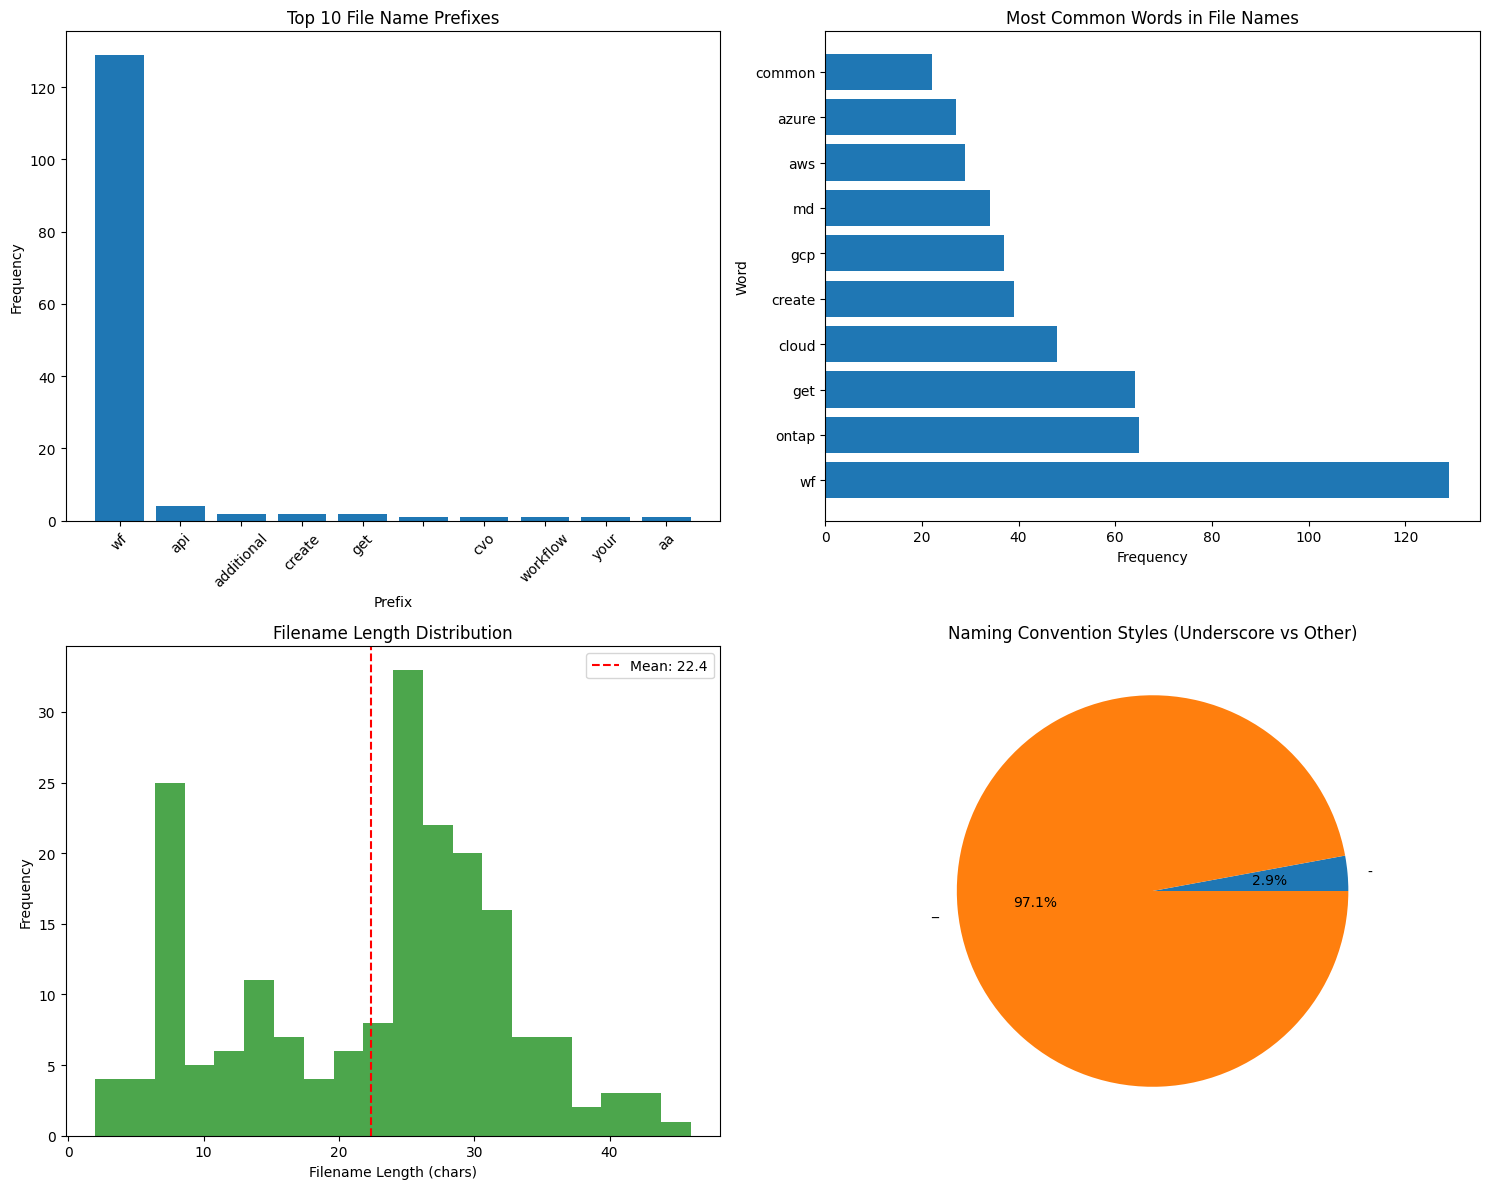

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

top_prefixes = dict(sorted(naming_patterns['prefixes'].items(), key=lambda x: x[1], reverse=True)[:10])
axes[0, 0].bar(top_prefixes.keys(), top_prefixes.values())
axes[0, 0].set_xlabel('Prefix')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Top 10 File Name Prefixes')
axes[0, 0].tick_params(axis='x', rotation=45)

top_words = dict(sorted(naming_patterns['words'].items(), key=lambda x: x[1], reverse=True)[:10])
axes[0, 1].barh(list(top_words.keys()), list(top_words.values()))
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Word')
axes[0, 1].set_title('Most Common Words in File Names')

axes[1, 0].hist(naming_patterns['lengths'], bins=20, alpha=0.7, color='green')
axes[1, 0].axvline(np.mean(naming_patterns['lengths']), color='red', linestyle='--',
                    label=f'Mean: {np.mean(naming_patterns["lengths"]):.1f}')
axes[1, 0].set_xlabel('Filename Length (chars)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Filename Length Distribution')
axes[1, 0].legend()

separators = naming_patterns['separators']
axes[1, 1].pie(separators.values(), labels=separators.keys(), autopct='%1.1f%%')
axes[1, 1].set_title('Naming Convention Styles (Underscore vs Other)')

plt.tight_layout()
plt.show()

### _Pattern-Based File Clustering_

We grouped files based on naming conventions to infer their functional roles. The majority fall under the `workflows` cluster, indicating task specific procedures. Other clusters like `read_operations`, `create_operations`, and `api_reference` are far less common. While this clustering helps categorize the repository by purpose, the imbalance may present challenges when generalizing intent-based metadata across all files.


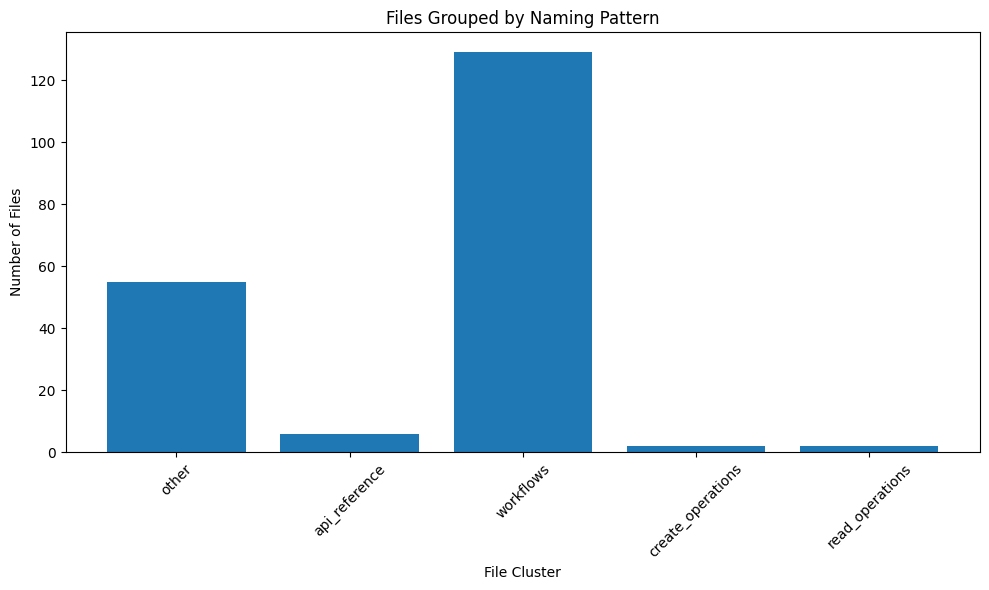

File Clustering Summary:
             cluster  count                                           examples
0              other     55         legal-notices.adoc, project.yml, README.md
1      api_reference      6  api_reference.adoc, api_ref_definitions.adoc, ...
2          workflows    129  wf_aws_cloud_add_capacity.adoc, wf_aws_cloud_c...
3  create_operations      2  create_service_token.adoc, create_user_token.adoc
4    read_operations      2             get_identifiers.adoc, get_nss_key.adoc


In [17]:
def cluster_files_by_pattern(df):
    
    clusters = defaultdict(list)
    
    for idx, row in df.iterrows():
        filename = row['filename']
        name_without_ext = filename.rsplit('.', 1)[0]
        
        if name_without_ext.startswith('wf_'):
            clusters['workflows'].append(filename)
        elif name_without_ext.startswith('get_'):
            clusters['read_operations'].append(filename)
        elif name_without_ext.startswith('create_'):
            clusters['create_operations'].append(filename)
        elif name_without_ext.startswith('update_'):
            clusters['update_operations'].append(filename)
        elif name_without_ext.startswith('delete_'):
            clusters['delete_operations'].append(filename)
        elif 'api' in name_without_ext.lower():
            clusters['api_reference'].append(filename)
        elif 'guide' in name_without_ext.lower() or 'tutorial' in name_without_ext.lower():
            clusters['guides'].append(filename)
        else:
            clusters['other'].append(filename)
    
    cluster_summary = pd.DataFrame([
        {'cluster': k, 'count': len(v), 'examples': ', '.join(v[:3])}
        for k, v in clusters.items()
    ])
    
    return cluster_summary, clusters

cluster_summary, file_clusters = cluster_files_by_pattern(df)

plt.figure(figsize=(10, 6))
plt.bar(cluster_summary['cluster'], cluster_summary['count'])
plt.xlabel('File Cluster')
plt.ylabel('Number of Files')
plt.title('Files Grouped by Naming Pattern')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("File Clustering Summary:")
print(cluster_summary)

In [19]:
print(df.columns)

Index(['filename', 'path', 'directory', 'extension', 'size_bytes', 'content',
       'depth', 'line_count', 'word_count', 'char_count', 'avg_line_length',
       'avg_word_length', 'h1_count', 'h2_count', 'h3_count', 'total_headers',
       'internal_links', 'external_links', 'total_links', 'link_density',
       'code_blocks', 'inline_code', 'api_endpoints', 'has_toc',
       'has_examples', 'is_config', 'is_documentation'],
      dtype='object')


In [20]:
# Export cluster_summary directly (separate file from doc_metadata.json)
output_path = "../visualization/data/cluster_summary.json"
cluster_summary.to_json(output_path, orient="records", indent=2)

print(f"✅ Exported cluster_summary to {output_path}")


✅ Exported cluster_summary to ../visualization/data/cluster_summary.json


In [21]:
df_export = pd.DataFrame({
    "filename": df["filename"],
    "extension": df["extension"],
    "num_words": df["word_count"],
    "h1_count": df["h1_count"],
    "h2_count": df["h2_count"],
    "h3_count": df["h3_count"],
    "links": df["total_links"],
    "total_lines": df["line_count"],
    "code_lines": df["code_blocks"],
    "size_bytes": df["size_bytes"],
    "depth": df["depth"],
    "directory": df["directory"],
    "internal_links": df["internal_links"],
    "external_links": df["external_links"],
    # "cluster": df["cluster"]
})

output_path = "../visualization/data/doc_metadata.json"
df_export.to_json(output_path, orient="records", indent=2)

print(f"✅ Exported {len(df_export)} records with size_bytes for file size distribution to {output_path}")


✅ Exported 194 records with size_bytes for file size distribution to ../visualization/data/doc_metadata.json
